In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/Filtered Fashion Images/dataset_split-20250617T014348Z-1-001.zip" -d "/content/drive/MyDrive/Filtered Fashion Images/Unzipped"

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks

output_base ="/content/drive/MyDrive/Filtered Fashion Images/Unzipped/dataset_split"
train_dir = os.path.join(output_base, 'train')
test_dir  = os.path.join(output_base, 'test')
IMG_SIZE = (224, 224)       # ResNet50 default input size is 224x224
BATCH_SIZE = 32
SEED = 42


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1,      # reserve 10% of train for validation
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=SEED
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=SEED
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)


Found 13497 images belonging to 2 classes.
Found 1499 images belonging to 2 classes.
Found 2108 images belonging to 2 classes.
Class indices: {'generated': 0, 'original': 1}


In [ ]:
#build resnet50 model
base_model = ResNet50(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
# Add classification head
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)  # ensure batchnorm runs in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()
# original
# model.compile(
#     optimizer=optimizers.Adam(learning_rate=1e-4),
#     loss='binary_crossentropy',
#     metrics=['accuracy',
#              tf.keras.metrics.Precision(name='precision'),
#              tf.keras.metrics.Recall(name='recall'),
#              tf.keras.metrics.AUC(name='auc'),
#              F1Score(name='f1_score')],

#     run_eagerly=True

# )

# test
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=[
      'accuracy',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall   (name='recall'),
      tf.keras.metrics.AUC      (name='auc'),
      F1Score(name='f1_score')
    ]
)

In [ ]:
checkpoint_path = '/content/drive/MyDrive/projectImages/resnlet50__finetune/checkpoint.h5'

os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)
earlystop_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=len(train_generator) // 3,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // 3,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7781 - auc: 0.8400 - f1_score: 0.7839 - loss: 0.4706 - precision: 0.7736 - recall: 0.7948
Epoch 1: val_auc improved from -inf to 0.00000, saving model to /content/drive/MyDrive/projectImages/resnlet50__finetune/checkpoint.h5


140/140 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.7789 - auc: 0.8408 - f1_score: 0.7846 - loss: 0.4694 - precision: 0.7744 - recall: 0.7954 - val_accuracy: 0.9833 - val_auc: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_loss: 0.1001 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9679 - auc: 0.9855 - f1_score: 0.9683 - loss: 0.1312 - precision: 0.9637 - recall: 0.9730
Epoch 2: val_auc did not improve from 0.00000
140/140 ━━━━━━━━━━━━━━━━━━━━ 138s 993ms/step - accuracy: 0.9679 - auc: 0.9855 - f1_score: 0.9683 - loss: 0.1312 - precision: 0.9638 - recall: 0.9730 - val_accuracy: 0.9833 - val_auc: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_loss: 0.0829 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9793 - auc: 0.9852 - f1_score: 0.9799 - loss: 0.1136 - precision: 0.9809 - recall: 0.9789

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_auc did not improve from 0.00000
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 1.0000 - auc: 1.0000 - f1_score: 1.0000 - loss: 0.0540 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9833 - val_auc: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_loss: 0.1071 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.9751 - auc: 0.9836 - f1_score: 0.9747 - loss: 0.1196 - precision: 0.9703 - recall: 0.9792
Epoch 5: val_auc did not improve from 0.00000

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
140/140 ━━━━━━━━━━━━━━━━━━━━ 142s 668ms/step - accuracy: 0.9751 - auc: 0.9836 - f1_score: 0.9747 - loss: 0.1195 - precision: 0.9703 - recall: 0.9792 - val_accuracy: 0.9833 - val_auc: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_loss: 0.1015 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/20
140/140 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 385ms/step - accuracy: 0.8878 - auc: 0.5636 - f1_score: 0.4891 - loss: 0.3915 - precision: 0.4573 - recall: 0.5479
{'accuracy': 0.9117646813392639, 'auc': 0.9650634527206421, 'f1_score': 0.9215189218521118, 'loss': 0.2986705005168915, 'precision': 0.9215189814567566, 'recall': 0.9215189814567566}
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 330ms/step


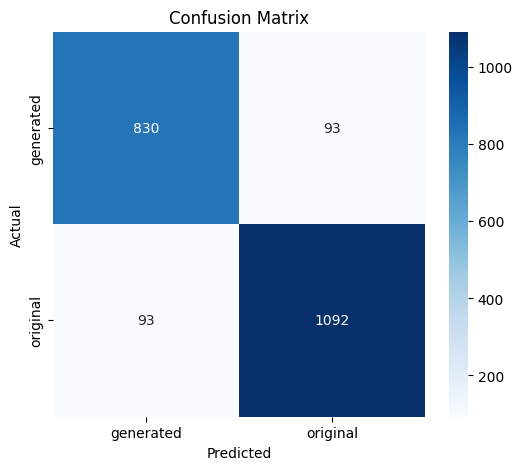

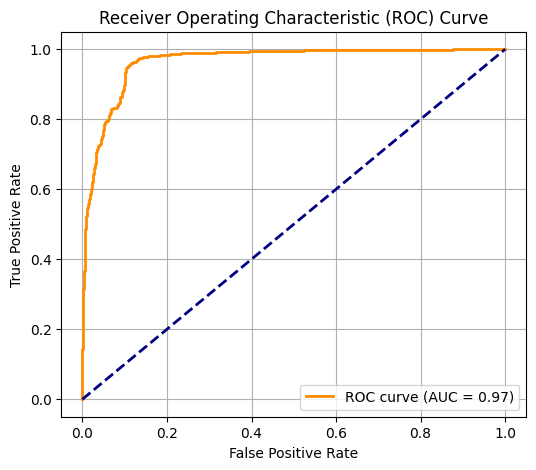

In [ ]:
# 4) Single evaluate call:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
results = model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=1,
    return_dict=True
)
print(results)


# Get ground truth and predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
# results = model.evaluate(
#     test_generator,
#     steps=len(test_generator),
#     verbose=1
# )

# # See in what order they come back:
# print(model.metrics_names)
# # e.g. ['loss', 'accuracy', 'precision', 'recall', 'auc', 'f1_score']

# loss, accuracy, precision, recall, auc, f1_score = results

# print(f"Test → loss: {loss:.4f}")
# print(f"       accuracy: {accuracy:.3f}")
# print(f"       precision: {precision:.3f}")
# print(f"       recall: {recall:.3f}")
# print(f"       AUC: {auc:.3f}")
# print(f"       F1‑score: {f1_score:.3f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 597ms/step - accuracy: 1.0000 - auc: 0.6250 - f1_score: 0.6250 - loss: 0.0071 - precision: 0.6250 - recall: 0.6250
['loss', 'compile_metrics']
Test → loss: 0.0078
       accuracy: 1.000
       precision: 1.000
       recall: 1.000
       AUC: 1.000
       F1‑score: 1.000
